In [2483]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display
plt.rcParams["figure.figsize"] = (18,6)
%matplotlib inline

## Data Collection

In [2484]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
"""
    Timestep for InvertedPendelum-v4 is 0.02
"""
obs, info = env.reset()
# ud = np.array([0])
# yd = obs
# done = False
# start = True

Tini = 1
n = 4
N = 30
m = 1
p = 4
T = (m+1)*(Tini + N + n) + 2
print(T)
render_collection = False

ud = []
yd = []

for i in range(T):
    action = env.action_space.sample()
    # action = np.random.randn(1,)
    # action = np.random.uniform(low=-0.5, high=0.5, size=(m,))
    obs, rew, done, info, _ = env.step(action)
    # if not start:
    #     obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
    # start = False

    if render_collection:
        plt.title(f"Action {action[0]:.3f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    ud = np.append(ud,action)
    yd = np.append(yd,obs)

env.close()
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

72
yd shape : (288,)   ud shape : (72,)


In [2485]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
rank = np.linalg.matrix_rank(H)
print(f'H has rank {rank} and shape {H.shape}')
if rank != H.shape[0]:
    raise ValueError

H has rank 35 and shape (35, 38)


In [2486]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

# u_ini = ud[:Tini]
# y_ini = yd[:p*Tini]
u_ini = np.array([0])
y_ini = np.array([0,0,0,0])
print(f'u ini : {u_ini}\ny ini : {y_ini}')


U = (31, 42), Up = (1, 42), Uf = (30, 42)
Y = (124, 42), Yp = (4, 42), Yf = (120, 42)
u ini : [0]
y ini : [0 0 0 0]


## Solver

In [2487]:
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
# sig_y = cp.Variable(p*Tini)

Q = np.diag([1,1,1,1])
Q = np.kron(np.eye(N), Q)
R = np.eye(N)*0.1

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm(g,1)*500 #+ cp.norm(sig_y, 1)*10000

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
env._max_episode_steps = 50
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]
done = False
iter = 0
render_solution = False
y_const = np.kron(np.ones(N), np.array([10, 0.2, 10, 10]))
u_const = np.ones(N)*3

while not done:

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,# + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= u_const,
    cp.abs(y) <= y_const
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.ECOS, verbose=False)
  # print(prob.variables()[1].value)
  action = prob.variables()[1].value[0]
  # print(prob._constraints)

  if render_solution:
    plt.title(f"Action {action:.3f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

  obs,_,done,_,_ = env.step([action])
  # obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
  
  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]
  iter += 1

In [2488]:
print(prob._status)

optimal


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


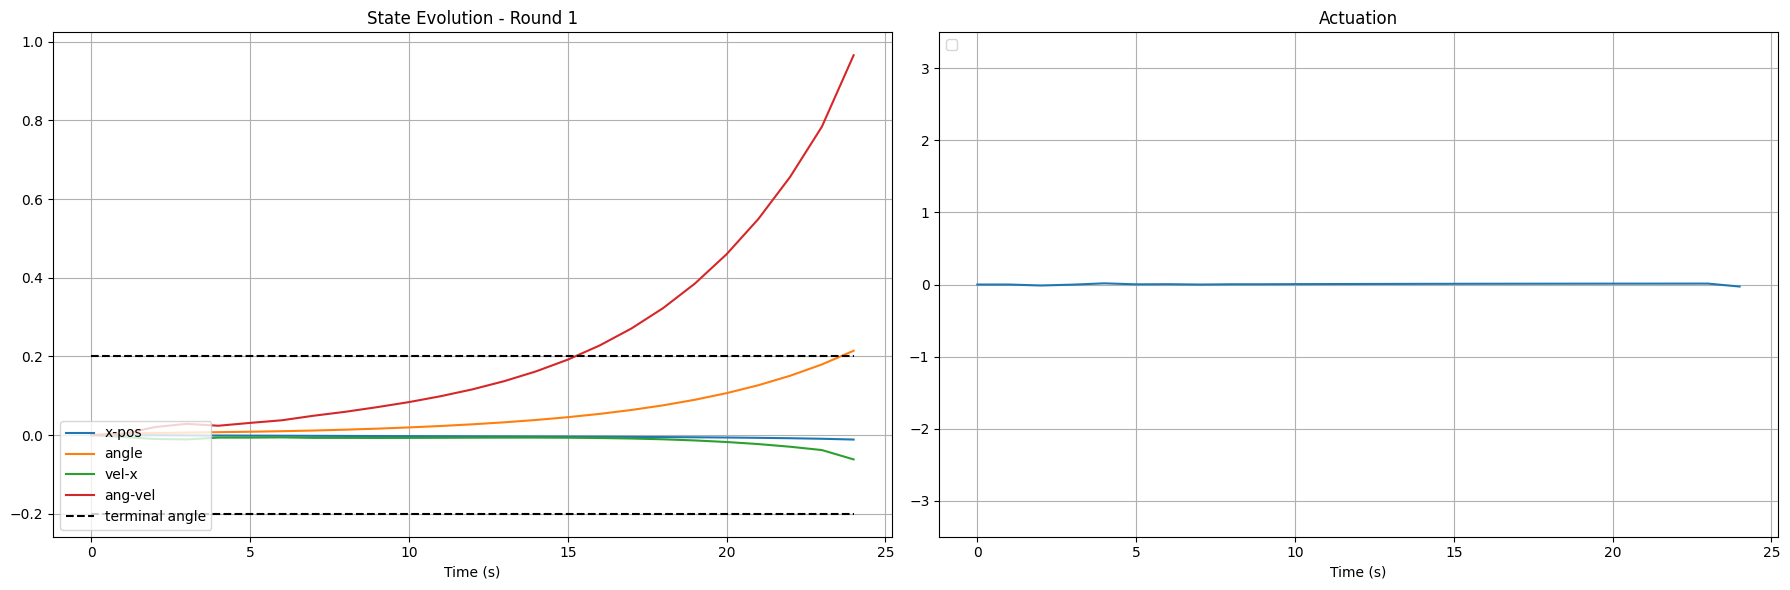

In [2489]:
T = len(uT)
yT = yT.reshape((T,4))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.legend(loc="lower left")
plt.xlabel('Time (s)')
plt.title("State Evolution - Round 1")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3.5,3.5))
plt.grid('on')
plt.tight_layout()

plt.show()

## Round 2

In [2490]:
yd2 = yT
ud2 = uT
T2 = len(ud2)
yd2 = yd2.reshape((T2*p,))
print(f'yd shape : {yd2.shape}   ud shape : {ud2.shape}')


yd shape : (100,)   ud shape : (25,)


In [2491]:
L = Tini + N + n
H = hankel(ud2[0:L], ud2[L-1:])
rank = np.linalg.matrix_rank(H)
print(f'H has rank {rank} and shape {H.shape}')
if rank != H.shape[0]:
    raise ValueError

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
L = Tini + N

U = hankel(ud2[0:L], ud2[L-1:])

Y = np.zeros((L*p, T2-L+1))
for i in range(0,T2-L+1):
    Y[:,i] = yd2[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = np.array([0])
y_ini = np.array([0,0,0,0])
print(f'u ini : {u_ini}\ny ini : {y_ini}')

U = (11, 19), Up = (1, 19), Uf = (10, 19)
Y = (44, 19), Yp = (4, 19), Yf = (40, 19)
u ini : [0]
y ini : [0 0 0 0]


In [ ]:
g = cp.Variable(T2 - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
# sig_y = cp.Variable(p*Tini)

Q = np.diag([1,1,1,1])
Q = np.kron(np.eye(N), Q)
R = np.eye(N)*0.1

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm(g,1)*500 #+ cp.norm(sig_y, 1)*10000

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
env._max_episode_steps = 50
obs = env.reset()
yT2 = [*y_ini]
uT2 = [*u_ini]
done = False
iter = 0
render_solution = False
y_const = np.kron(np.ones(N), np.array([2, 0.2, 2, 2]))
u_const = np.ones(N)*3

while not done:
  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,# + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= u_const,
    cp.abs(y) <= y_const
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.ECOS, verbose=False)
  # print(prob.variables()[1].value)
  action = prob.variables()[1].value[0]
  # print(prob._constraints)

  if render_solution:
    plt.title(f"Action {action:.3f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)

  obs,_,done,_,_ = env.step([action])
  # obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT2 = np.append(yT2, obs)
  uT2 = np.append(uT2, action)
  
  u_ini = uT2[-Tini:]
  y_ini = yT2[-p*Tini:]
  iter += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


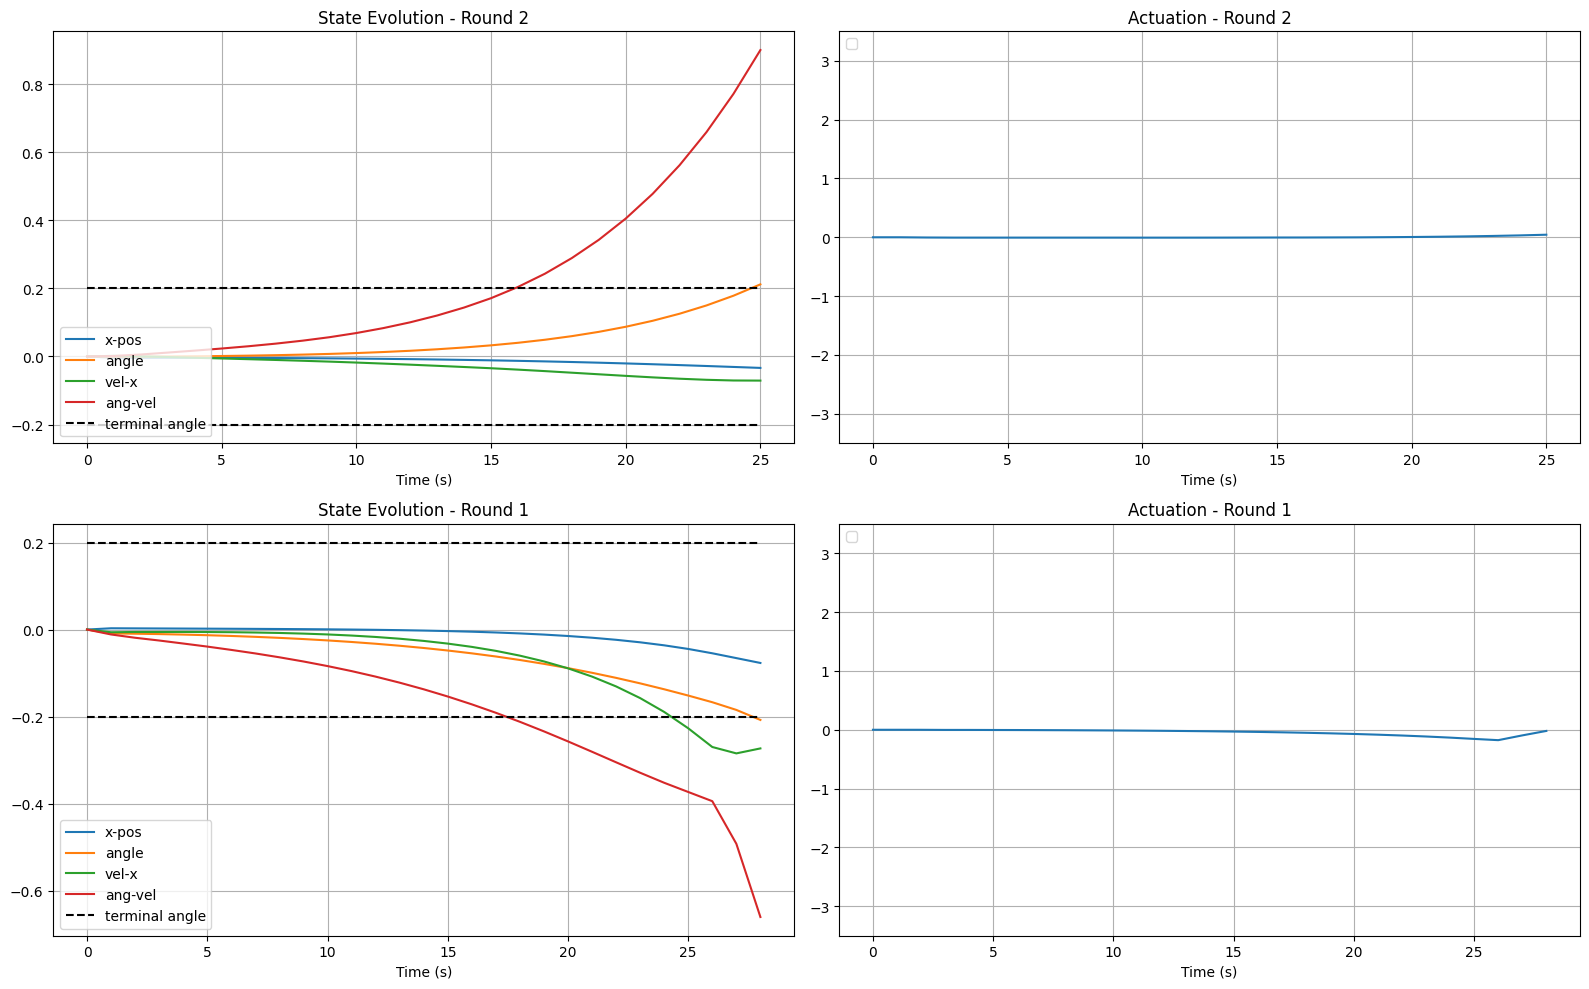

In [ ]:
T2 = len(uT2)
yT2 = yT2.reshape((T2,4))
T = len(uT)
yT = yT.reshape((T,4))
plt.rcParams["figure.figsize"] = (16,10)

plt.subplot(2,2,1)
plt.plot(range(0,T2), yT2, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T2), np.ones(T2)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T2), -np.ones(T2)*0.2, 'k--')
plt.legend(loc="lower left")
plt.xlabel('Time (s)')
plt.title("State Evolution - Round 2")
plt.grid('on')
plt.tight_layout()

plt.subplot(2,2,2)
plt.plot(range(0,T2), uT2)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation - Round 2")
plt.ylim((-3.5,3.5))
plt.grid('on')
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.plot(range(0,T), np.ones(T)*0.2, 'k--',label='terminal angle')
plt.plot(range(0,T), -np.ones(T)*0.2, 'k--')
plt.legend(loc="lower left")
plt.xlabel('Time (s)')
plt.title("State Evolution - Round 1")
plt.grid('on')
plt.tight_layout()

plt.subplot(2,2,4)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation - Round 1")
plt.ylim((-3.5,3.5))
plt.grid('on')
plt.tight_layout()

plt.show()